In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26, read_datasets
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot, select_ACC, select_Equator
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted, CoarsenKochkovMinMax
from helpers.state_functions import *

import hvplot.xarray
import hvplot
import cmocean

%load_ext autoreload
%autoreload 3

# Reading data on Greene

In [2]:
ds = read_datasets(['validate'], [4])['validate-4']

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4


Text(0.5, 1.0, '0194-04-13 12:00:00, 3508.633056640625')

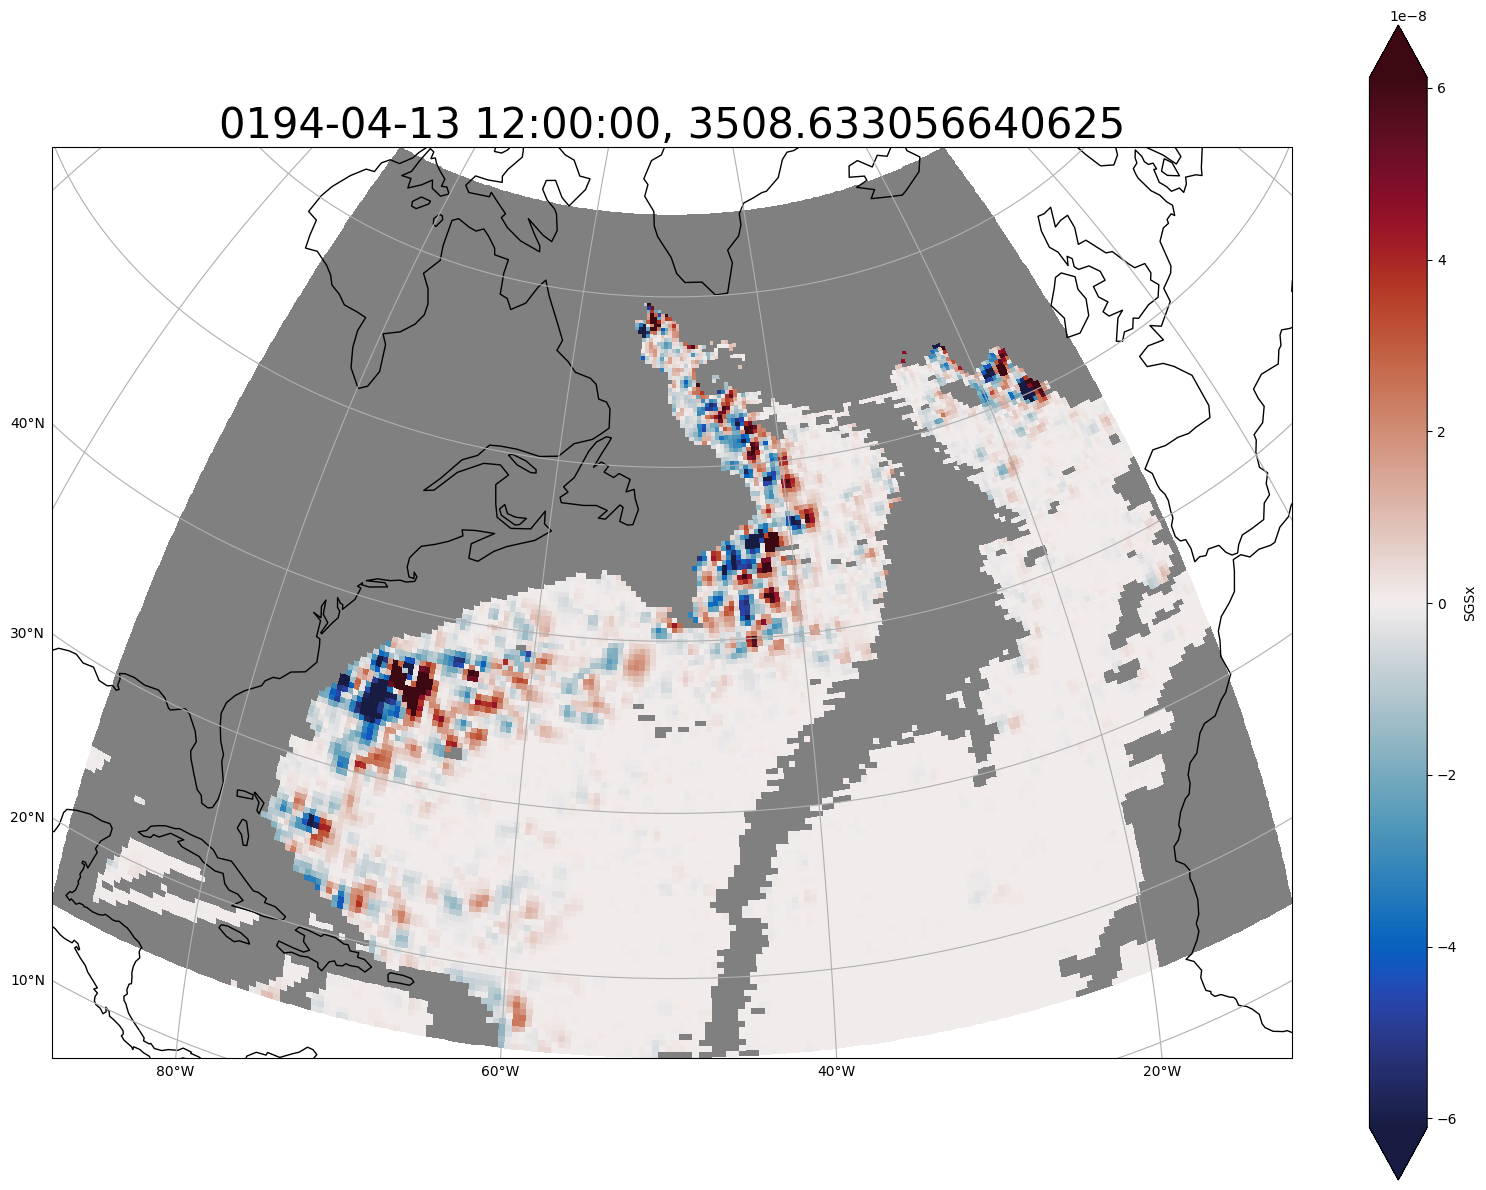

In [3]:
ds2d = ds.select2d(zl=8)
plot(ds2d.nanvar(ds2d.data.SGSx))
plt.title(f'{ds2d.data.time.values}, {ds2d.data.zl.values}', fontsize=30)

Correlation: 0.6934024225322433
Relative Error: 0.7286759613994569
R2 =  0.4614990367874712
R2 max =  0.48094988337620526
Optinal scaling: 0.8325678174491141
Nans [test/control]: [17666, 17666]


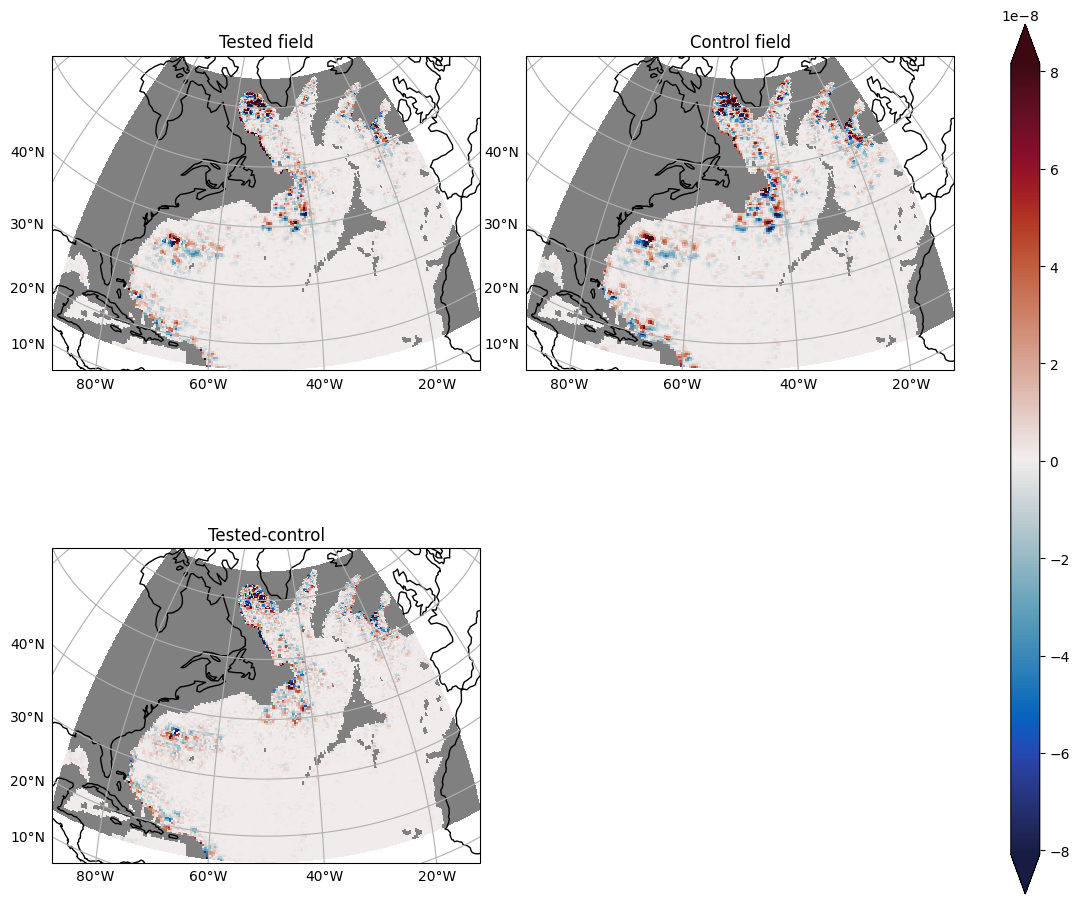

In [84]:
ds2d = ds.select2d(zl=7, time=0)
ann_Txy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txx_Tyy_epoch_2000.nc')
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)['ZB20v']*1.35), ds2d.nanvar(ds2d.data.SGSy), selector=select_NA)

Correlation: 0.9237629313056089
Relative Error: 0.3429763240625278
R2 =  0.8460373556405116
R2 max =  0.853387087698757
Optinal scaling: 0.9150778890103493
Nans [test/control]: [20764, 20764]


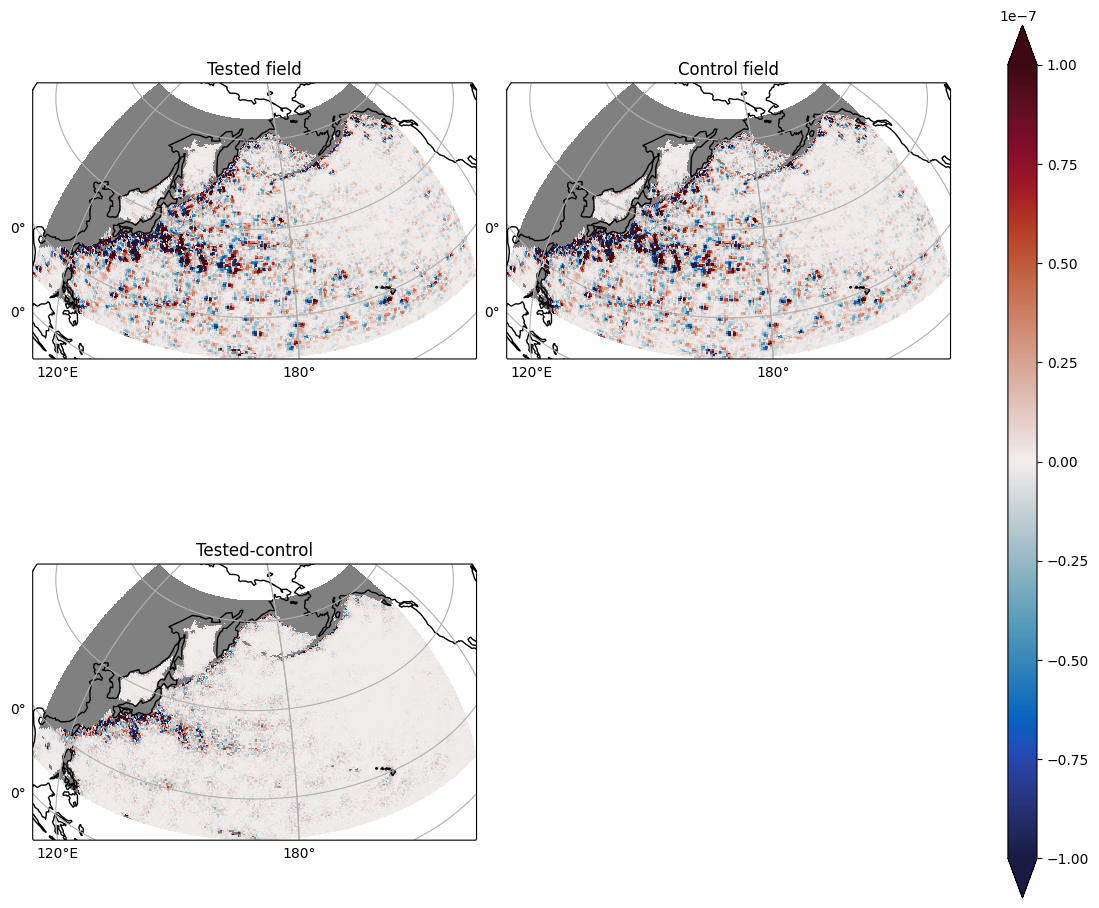

In [4]:
ds2d = ds.select2d(zl=3, time=0)
ann_Txy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txx_Tyy_epoch_2000.nc')
ann_Txy_sym = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txy_epoch_2000.nc')
ann_Txx_Tyy_sym = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txx_Tyy_epoch_2000.nc')
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)['ZB20u']), ds2d.nanvar(ds2d.state.ANN(ann_Txy_sym,ann_Txx_Tyy_sym)['ZB20u']), 
        selector=select_Pacific, vmax = 10e-8, vmin=-10e-8)

# Normalization of input features

In [5]:
ds2d = ds.select2d(zl=0, time=0)
ann_Txy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txx_Tyy_epoch_2000.nc')
prediction = ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)

In [16]:
for key in ['ZB20u', 'ZB20v', 'Txx', 'Txy', 'Tyy']:
    print(key, float(ds2d.nanvar(prediction[key]).std()))

ZB20u 8.919600664313859e-08
ZB20v 8.867400546762378e-08
Txx 0.005370180795959254
Txy 0.0028896510799977177
Tyy 0.006034607865284507


In [14]:
for key in ['sh_xx', 'sh_xy', 'vort_xy']:
    print(key, float(prediction[key].std()))

sh_xx 1.502939539932413e-06
sh_xy 1.3597741599369328e-06
vort_xy 1.9523954506439622e-06


In [15]:
(1e-6)**2 * (ds2d.param.dxT * ds2d.param.dyT).mean()

<xarray.DataArray ()>
array(0.00083459)
Coordinates:
    zl       float64 5.034

# Simple training script

In [3]:
from helpers.train_ann import train_ANN

In [16]:
ann_Txy, ann_Txx_Tyy, logger = train_ANN(time_iters=1000, print_iters=10)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [1.143903, 1.158397]
Factor: 15, depth: 0, MSE train/validate: [1.060304, 1.084349]
Iter/num_iters [10/1000]. Iter time/Remaining time in seconds: [0.56/591.4]
Factor: 12, depth: 0, MSE train/validate: [0.998607, 1.063141]
Factor: 15, depth: 0, MSE train/validate: [0.971053, 0.986936]
Iter/num_iters [20/1000]. Iter time/Remaining time in seconds: [0.56/568.8]
Factor: 12, depth: 0, MSE train/validate: [0.899062, 0.907822]
Factor: 15, depth: 0, MSE train/validate: [0.961181, 0.936922]
Iter/num_iters [30/1000]. Iter time/Remaining time in seconds: [0.56/556.4]
Factor: 12, depth: 0, MSE train/validate: [0.880290, 0.860

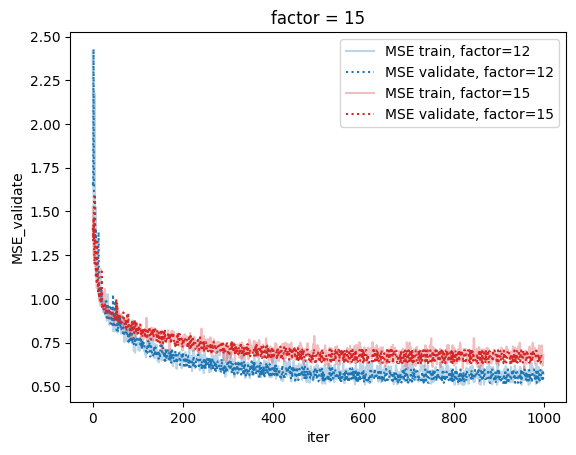

In [25]:
logger.MSE_train.sel(factor=12).plot(color='tab:blue', label='MSE train, factor=12', alpha=0.3)
logger.MSE_validate.sel(factor=12).plot(color='tab:blue', ls=':', label='MSE validate, factor=12')

logger.MSE_train.sel(factor=15).plot(color='tab:red', label='MSE train, factor=15', alpha=0.3)
logger.MSE_validate.sel(factor=15).plot(color='tab:red', ls=':', label='MSE validate, factor=15')
plt.legend()

In [26]:
ds = read_datasets(['test'], [12])['test-12']

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12


Correlation: 0.5913286266150832
Relative Error: 0.8170916348817914
R2 =  0.34908953634344553
R2 max =  0.3498534335899428
Optinal scaling: 1.049018208730356
Nans [test/control]: [948, 948]


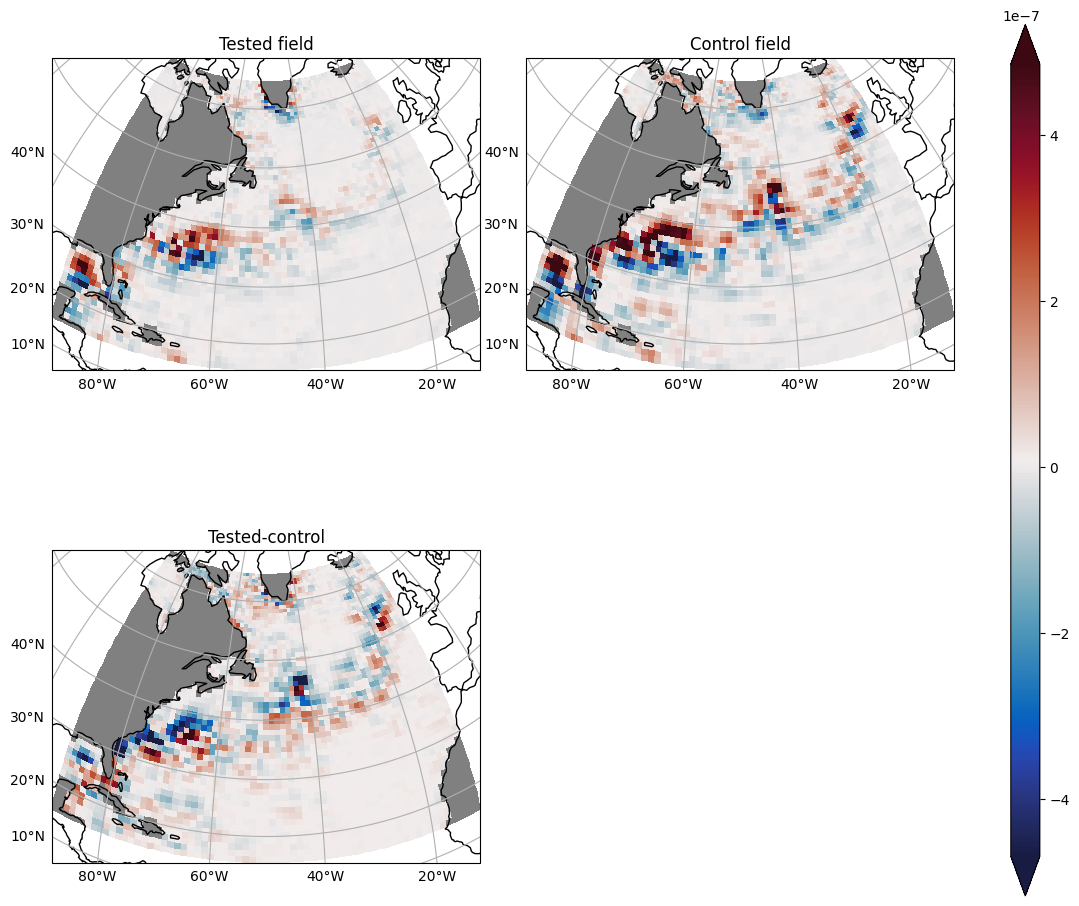

In [28]:
ds2d = ds.select2d(zl=0)
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)['ZB20v']), ds2d.nanvar(ds2d.data.SGSy), selector=select_NA)

# Off dimensional scaling

In [17]:
from helpers.train_ann import train_ANN

In [35]:
ann_Txy, ann_Txx_Tyy, logger = train_ANN(time_iters=1000, print_iters=50, dimensional_scaling=False)

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-15
Factor: 12, depth: 0, MSE train/validate: [0.975675, 0.978889]
Factor: 15, depth: 0, MSE train/validate: [0.987283, 0.987101]
Iter/num_iters [50/1000]. Iter time/Remaining time in seconds: [0.96/660.1]
Factor: 12, depth: 0, MSE train/validate: [0.950152, 0.940990]
Factor: 15, depth: 0, MSE train/validate: [0.965926, 0.963087]
Iter/num_iters [100/1000]. Iter time/Remaining time in seconds: [0.63/673.5]
Factor: 12, depth: 0, MSE train/validate: [0.901856, 0.902869]
Factor: 15, depth: 0, MSE train/validate: [0.935096, 0.939790]
Iter/num_iters [150/1000]. Iter time/Remaining time in seconds: [0.66/643.9]
Factor: 12, depth: 0, MSE train/validate: [0.861953, 0.8

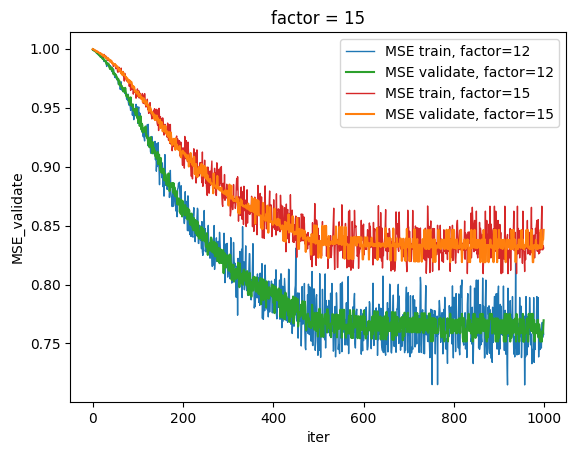

In [40]:
logger.MSE_train.sel(factor=12,depth=0).plot(color='tab:blue', label='MSE train, factor=12', alpha=1, lw=1)
logger.MSE_validate.sel(factor=12,depth=0).plot(color='tab:green', ls='-', label='MSE validate, factor=12')

logger.MSE_train.sel(factor=15,depth=0).plot(color='tab:red', label='MSE train, factor=15', lw=1)
logger.MSE_validate.sel(factor=15,depth=0).plot(color='tab:orange', ls='-', label='MSE validate, factor=15')


plt.legend()

In [41]:
ds = read_datasets(['test'], [12])['test-12']

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-12


Correlation: 0.5193204015963081
Relative Error: 0.9198297601742009
R2 =  0.25991329807243946
R2 max =  0.27267627131187866
Optinal scaling: 1.2760760853251762
Nans [test/control]: [948, 948]


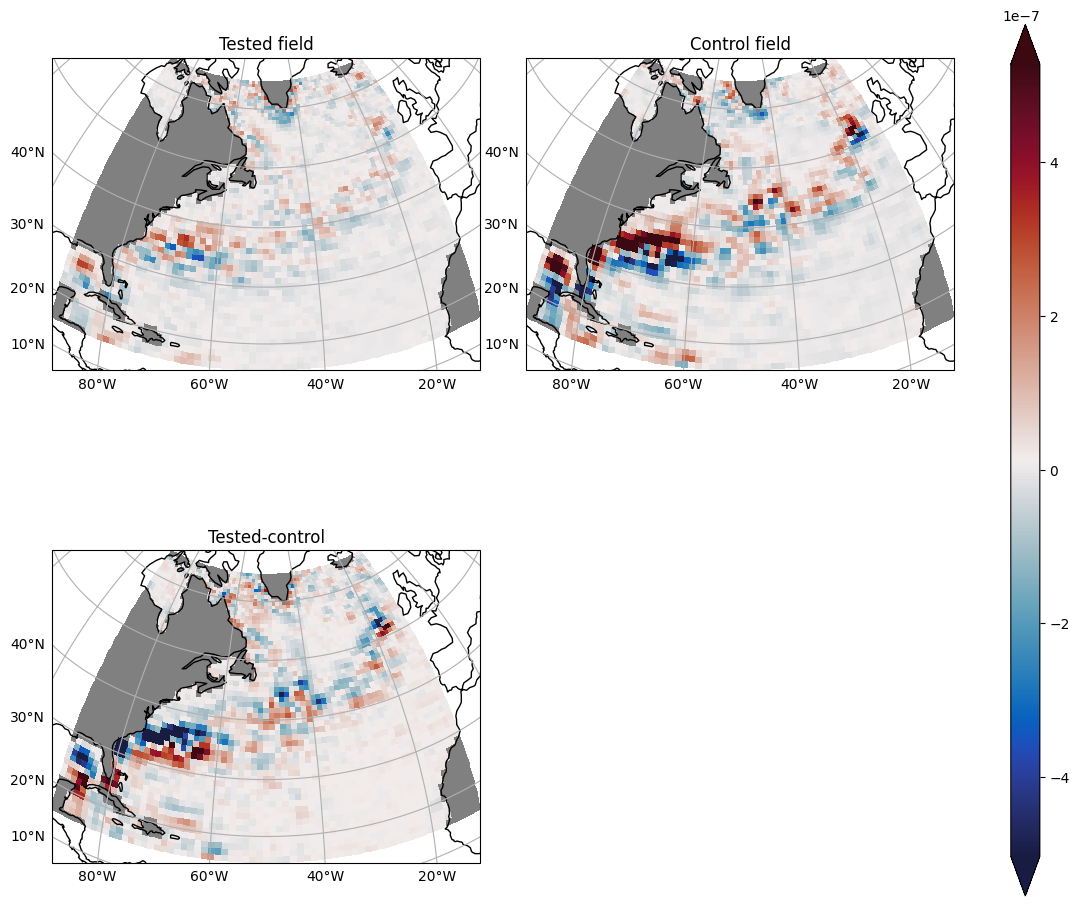

In [48]:
ds2d = ds.select2d(zl=0)
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy,dimensional_scaling=False)['ZB20v']), ds2d.nanvar(ds2d.data.SGSy), selector=select_NA)